In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

C:\Users\halla\anaconda3\envs\MachineLearnign\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Define learning parameters

In [2]:
# learning parameters
batch_size = 512
epochs = 200
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [15]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir  input
!mkdir  outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 11542290.49it/s]


Extracting input/data\MNIST\raw\train-images-idx3-ubyte.gz to input/data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 21677826.38it/s]


Extracting input/data\MNIST\raw\train-labels-idx1-ubyte.gz to input/data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 11342231.12it/s]


Extracting input/data\MNIST\raw\t10k-images-idx3-ubyte.gz to input/data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting input/data\MNIST\raw\t10k-labels-idx1-ubyte.gz to input/data\MNIST\raw



# Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [7]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [8]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [9]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [10]:
# to create real labels (1s)
def label_real(size):
    #Maninder: Creating true labels as 1.
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    #Maninder creating fake labels as 0.
    data = torch.zeros(size, 1)
    return data.to(device)


In [11]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [12]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [13]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

118it [00:15,  7.83it/s]                         


Epoch 1 of 200
Generator loss: 1.33923401, Discriminator loss: 0.90187850


118it [00:14,  8.12it/s]                         


Epoch 2 of 200
Generator loss: 1.46620637, Discriminator loss: 1.33338902


118it [00:14,  8.15it/s]                         


Epoch 3 of 200
Generator loss: 3.07767311, Discriminator loss: 1.13074047


118it [00:14,  8.14it/s]                         


Epoch 4 of 200
Generator loss: 1.24658442, Discriminator loss: 1.25341086


118it [00:14,  8.13it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


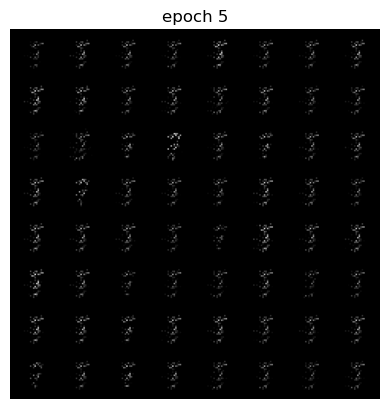

Epoch 5 of 200
Generator loss: 1.36215992, Discriminator loss: 1.18400754


118it [00:14,  8.11it/s]                         


Epoch 6 of 200
Generator loss: 1.78280038, Discriminator loss: 1.02876666


118it [00:14,  8.07it/s]                         


Epoch 7 of 200
Generator loss: 2.71025690, Discriminator loss: 1.15451578


118it [00:14,  8.03it/s]                         


Epoch 8 of 200
Generator loss: 2.92773979, Discriminator loss: 1.03936313


118it [00:14,  7.89it/s]                         


Epoch 9 of 200
Generator loss: 2.08029414, Discriminator loss: 1.12665336


118it [00:14,  8.07it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


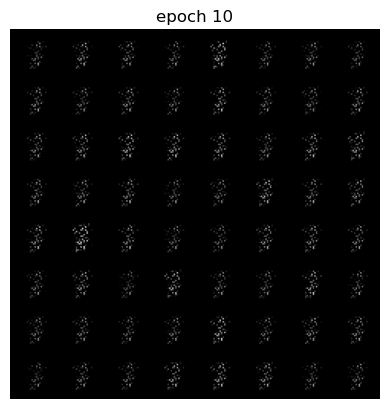

Epoch 10 of 200
Generator loss: 1.42848658, Discriminator loss: 1.12151681


118it [00:15,  7.58it/s]                         


Epoch 11 of 200
Generator loss: 1.86672680, Discriminator loss: 1.23691313


118it [00:14,  7.91it/s]                         


Epoch 12 of 200
Generator loss: 2.10702856, Discriminator loss: 1.34188740


118it [00:14,  7.96it/s]                         


Epoch 13 of 200
Generator loss: 0.95759657, Discriminator loss: 1.37372490


118it [00:14,  7.99it/s]                         


Epoch 14 of 200
Generator loss: 1.02215548, Discriminator loss: 1.14702541


118it [00:14,  7.89it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


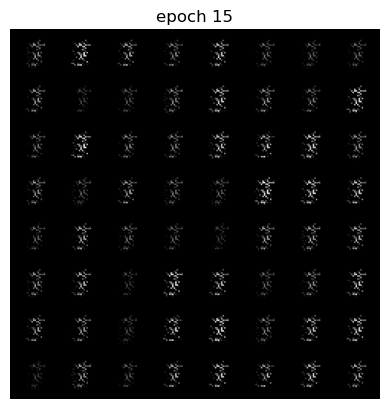

Epoch 15 of 200
Generator loss: 1.03443582, Discriminator loss: 1.33057369


118it [00:14,  7.88it/s]                         


Epoch 16 of 200
Generator loss: 2.51321312, Discriminator loss: 0.85395932


118it [00:14,  7.98it/s]                         


Epoch 17 of 200
Generator loss: 1.65867855, Discriminator loss: 1.16072915


118it [00:15,  7.80it/s]                         


Epoch 18 of 200
Generator loss: 1.28795460, Discriminator loss: 1.13674013


118it [00:15,  7.87it/s]                         


Epoch 19 of 200
Generator loss: 1.65727370, Discriminator loss: 1.07028684


118it [00:15,  7.72it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


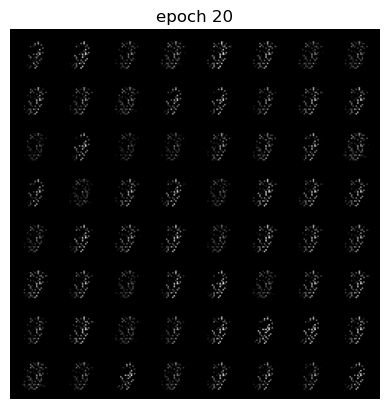

Epoch 20 of 200
Generator loss: 1.39254580, Discriminator loss: 1.13337919


118it [00:15,  7.77it/s]                         


Epoch 21 of 200
Generator loss: 1.54492867, Discriminator loss: 1.26079739


118it [00:14,  7.88it/s]                         


Epoch 22 of 200
Generator loss: 1.56668784, Discriminator loss: 1.10739401


118it [00:14,  7.90it/s]                         


Epoch 23 of 200
Generator loss: 1.86014703, Discriminator loss: 1.14431173


118it [00:16,  7.29it/s]                         


Epoch 24 of 200
Generator loss: 1.40838082, Discriminator loss: 0.97794915


118it [00:15,  7.59it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


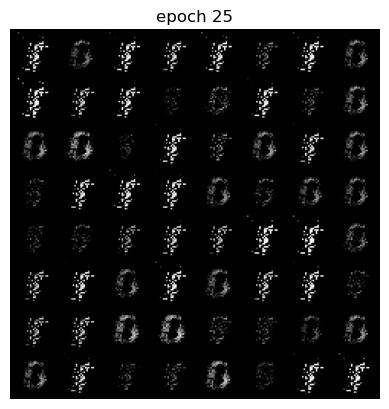

Epoch 25 of 200
Generator loss: 1.51504294, Discriminator loss: 0.96727495


118it [00:15,  7.64it/s]                         


Epoch 26 of 200
Generator loss: 1.98052888, Discriminator loss: 0.94031907


118it [00:14,  7.90it/s]                         


Epoch 27 of 200
Generator loss: 1.52118128, Discriminator loss: 0.78520607


118it [00:15,  7.62it/s]                         


Epoch 28 of 200
Generator loss: 1.77964237, Discriminator loss: 0.85599061


118it [00:15,  7.48it/s]                         


Epoch 29 of 200
Generator loss: 1.78112548, Discriminator loss: 0.81255799


118it [00:15,  7.48it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


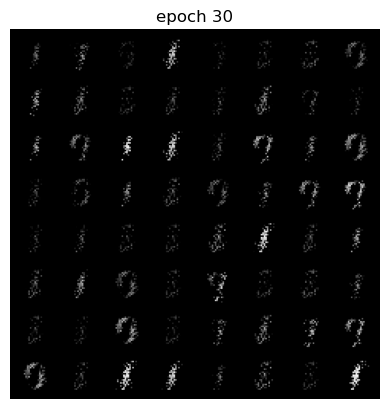

Epoch 30 of 200
Generator loss: 1.91493007, Discriminator loss: 0.73288652


118it [00:15,  7.61it/s]                         


Epoch 31 of 200
Generator loss: 2.12427910, Discriminator loss: 0.69274138


118it [00:15,  7.63it/s]                         


Epoch 32 of 200
Generator loss: 2.42322089, Discriminator loss: 0.84278694


118it [00:15,  7.70it/s]                         


Epoch 33 of 200
Generator loss: 2.40496272, Discriminator loss: 0.62397935


118it [00:15,  7.58it/s]                         


Epoch 34 of 200
Generator loss: 2.29390197, Discriminator loss: 0.69120680


118it [00:15,  7.73it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


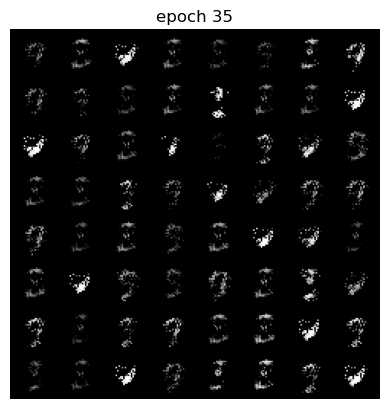

Epoch 35 of 200
Generator loss: 2.14386345, Discriminator loss: 0.68328258


118it [00:15,  7.83it/s]                         


Epoch 36 of 200
Generator loss: 2.20718506, Discriminator loss: 0.69494489


118it [00:14,  7.96it/s]                         


Epoch 37 of 200
Generator loss: 1.85523448, Discriminator loss: 0.84669981


118it [00:15,  7.68it/s]                         


Epoch 38 of 200
Generator loss: 2.20739743, Discriminator loss: 0.71379431


118it [00:15,  7.72it/s]                         


Epoch 39 of 200
Generator loss: 2.23277600, Discriminator loss: 0.62359205


118it [00:15,  7.59it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


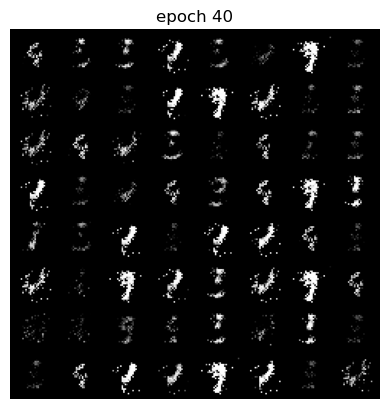

Epoch 40 of 200
Generator loss: 2.01921405, Discriminator loss: 0.75082793


118it [00:15,  7.62it/s]                         


Epoch 41 of 200
Generator loss: 2.18583952, Discriminator loss: 0.70872411


118it [00:15,  7.64it/s]                         


Epoch 42 of 200
Generator loss: 2.00371693, Discriminator loss: 0.76174398


118it [00:16,  7.33it/s]                         


Epoch 43 of 200
Generator loss: 1.81925773, Discriminator loss: 0.77978081


118it [00:15,  7.51it/s]                         


Epoch 44 of 200
Generator loss: 2.07889639, Discriminator loss: 0.63883708


118it [00:16,  7.36it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


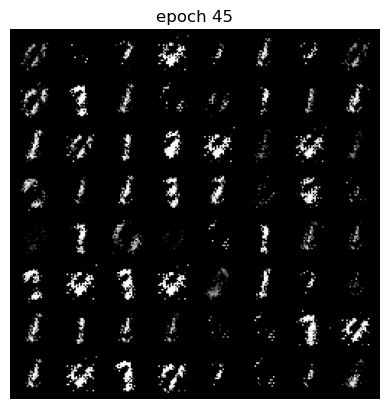

Epoch 45 of 200
Generator loss: 2.30948695, Discriminator loss: 0.68214930


118it [00:15,  7.40it/s]                         


Epoch 46 of 200
Generator loss: 2.50532635, Discriminator loss: 0.68425994


118it [00:16,  7.33it/s]                         


Epoch 47 of 200
Generator loss: 2.28600501, Discriminator loss: 0.71619947


118it [00:15,  7.39it/s]                         


Epoch 48 of 200
Generator loss: 2.25045452, Discriminator loss: 0.74727416


118it [00:16,  7.26it/s]                         


Epoch 49 of 200
Generator loss: 2.12688980, Discriminator loss: 0.77425035


118it [00:16,  7.19it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


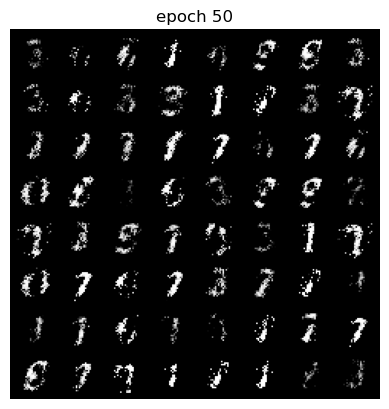

Epoch 50 of 200
Generator loss: 2.06333329, Discriminator loss: 0.71870172


118it [00:15,  7.66it/s]                         


Epoch 51 of 200
Generator loss: 2.04552122, Discriminator loss: 0.72286453


118it [00:15,  7.76it/s]                         


Epoch 52 of 200
Generator loss: 2.23374469, Discriminator loss: 0.75507484


118it [00:15,  7.83it/s]                         


Epoch 53 of 200
Generator loss: 2.25267964, Discriminator loss: 0.68430904


118it [00:15,  7.85it/s]                         


Epoch 54 of 200
Generator loss: 2.14200114, Discriminator loss: 0.74169693


118it [00:14,  7.89it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


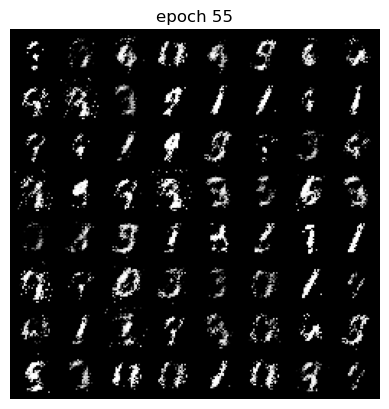

Epoch 55 of 200
Generator loss: 2.00033086, Discriminator loss: 0.82390168


118it [00:14,  7.95it/s]                         


Epoch 56 of 200
Generator loss: 1.89143842, Discriminator loss: 0.80723139


118it [00:15,  7.78it/s]                         


Epoch 57 of 200
Generator loss: 1.93228266, Discriminator loss: 0.80326056


118it [00:15,  7.75it/s]                         


Epoch 58 of 200
Generator loss: 1.90783233, Discriminator loss: 0.78502738


118it [00:14,  7.96it/s]                         


Epoch 59 of 200
Generator loss: 1.91232445, Discriminator loss: 0.82578729


118it [00:14,  7.89it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


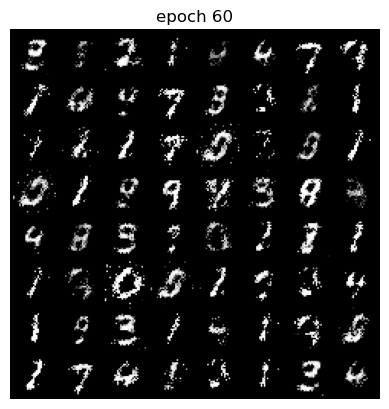

Epoch 60 of 200
Generator loss: 1.93273449, Discriminator loss: 0.79257596


118it [00:14,  7.87it/s]                         


Epoch 61 of 200
Generator loss: 1.96754459, Discriminator loss: 0.77265359


118it [00:14,  7.95it/s]                         


Epoch 62 of 200
Generator loss: 1.88076958, Discriminator loss: 0.78990210


118it [00:14,  7.89it/s]                         


Epoch 63 of 200
Generator loss: 2.17293363, Discriminator loss: 0.73607740


118it [00:15,  7.83it/s]                         


Epoch 64 of 200
Generator loss: 2.04430319, Discriminator loss: 0.78273625


118it [00:14,  7.95it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


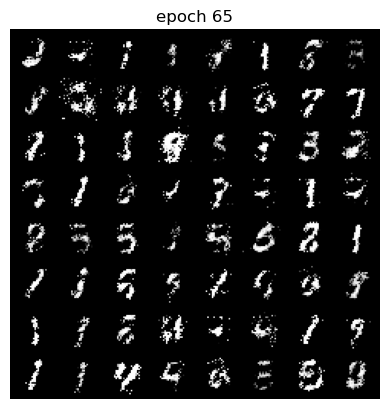

Epoch 65 of 200
Generator loss: 1.77328962, Discriminator loss: 0.85065402


118it [00:14,  7.87it/s]                         


Epoch 66 of 200
Generator loss: 2.04533891, Discriminator loss: 0.74732408


118it [00:15,  7.77it/s]                         


Epoch 67 of 200
Generator loss: 2.05240943, Discriminator loss: 0.78450187


118it [00:15,  7.70it/s]                         


Epoch 68 of 200
Generator loss: 1.92812810, Discriminator loss: 0.83055716


118it [00:14,  7.88it/s]                         


Epoch 69 of 200
Generator loss: 2.08714582, Discriminator loss: 0.79543720


118it [00:14,  7.98it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


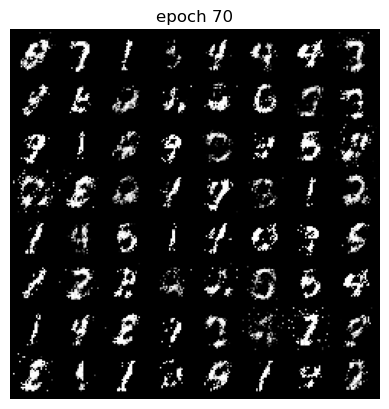

Epoch 70 of 200
Generator loss: 2.09952487, Discriminator loss: 0.74463914


118it [00:14,  7.99it/s]                         


Epoch 71 of 200
Generator loss: 2.23227520, Discriminator loss: 0.69985612


118it [00:14,  7.98it/s]                         


Epoch 72 of 200
Generator loss: 2.25038654, Discriminator loss: 0.70454504


118it [00:14,  7.95it/s]                         


Epoch 73 of 200
Generator loss: 2.31914652, Discriminator loss: 0.73366939


118it [00:14,  7.89it/s]                         


Epoch 74 of 200
Generator loss: 2.37735183, Discriminator loss: 0.70063979


118it [00:14,  8.00it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


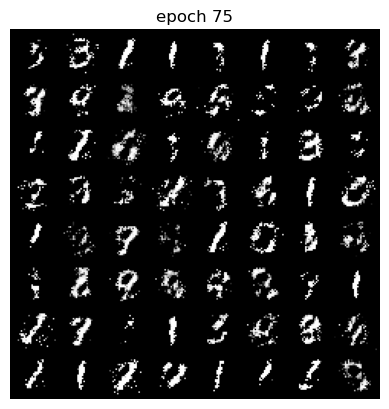

Epoch 75 of 200
Generator loss: 2.35664022, Discriminator loss: 0.68287463


118it [00:14,  7.94it/s]                         


Epoch 76 of 200
Generator loss: 2.54775473, Discriminator loss: 0.65264768


118it [00:14,  7.94it/s]                         


Epoch 77 of 200
Generator loss: 2.57199802, Discriminator loss: 0.66930785


118it [00:14,  8.00it/s]                         


Epoch 78 of 200
Generator loss: 2.21950805, Discriminator loss: 0.75792018


118it [00:14,  8.04it/s]                         


Epoch 79 of 200
Generator loss: 2.14840230, Discriminator loss: 0.74444097


118it [00:14,  8.00it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


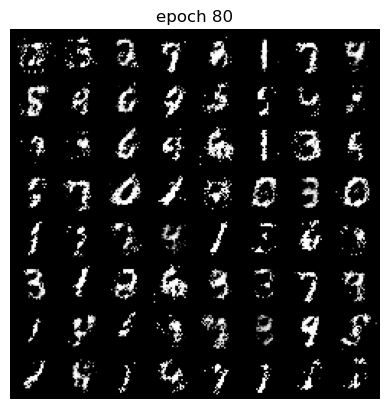

Epoch 80 of 200
Generator loss: 2.28393492, Discriminator loss: 0.72534431


118it [00:14,  8.00it/s]                         


Epoch 81 of 200
Generator loss: 2.31512369, Discriminator loss: 0.68631828


118it [00:14,  7.97it/s]                         


Epoch 82 of 200
Generator loss: 2.36507764, Discriminator loss: 0.66913297


118it [00:14,  7.94it/s]                         


Epoch 83 of 200
Generator loss: 2.25283500, Discriminator loss: 0.71884067


118it [00:14,  8.01it/s]                         


Epoch 84 of 200
Generator loss: 2.39779834, Discriminator loss: 0.65955980


118it [00:14,  7.99it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


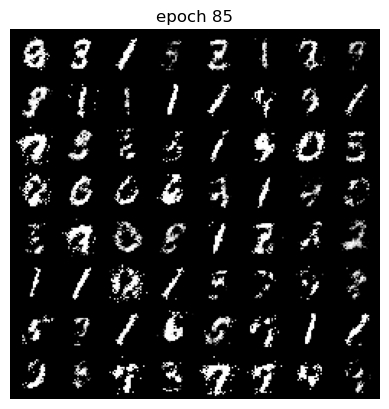

Epoch 85 of 200
Generator loss: 2.21648214, Discriminator loss: 0.70628653


118it [00:14,  7.96it/s]                         


Epoch 86 of 200
Generator loss: 2.16756013, Discriminator loss: 0.73356985


118it [00:15,  7.64it/s]                         


Epoch 87 of 200
Generator loss: 2.04061620, Discriminator loss: 0.76545723


118it [00:14,  7.92it/s]                         


Epoch 88 of 200
Generator loss: 2.04142279, Discriminator loss: 0.79400324


118it [00:15,  7.54it/s]                         


Epoch 89 of 200
Generator loss: 2.04218432, Discriminator loss: 0.76673855


118it [00:14,  7.95it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


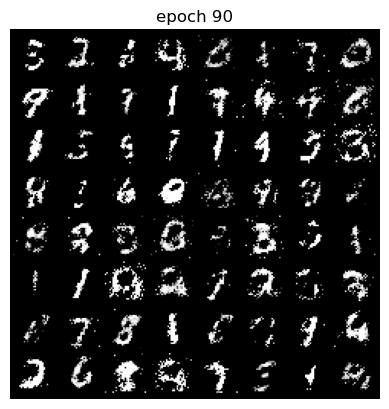

Epoch 90 of 200
Generator loss: 1.98720645, Discriminator loss: 0.75734151


118it [00:15,  7.85it/s]                         


Epoch 91 of 200
Generator loss: 1.90449154, Discriminator loss: 0.82319947


118it [00:14,  7.97it/s]                         


Epoch 92 of 200
Generator loss: 1.95100498, Discriminator loss: 0.80585460


118it [00:14,  7.97it/s]                         


Epoch 93 of 200
Generator loss: 1.86850885, Discriminator loss: 0.81600528


118it [00:15,  7.77it/s]                         


Epoch 94 of 200
Generator loss: 1.90770212, Discriminator loss: 0.82209363


118it [00:14,  7.97it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


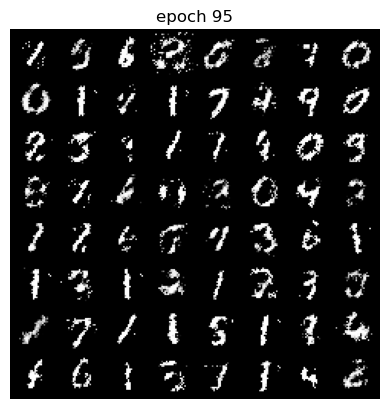

Epoch 95 of 200
Generator loss: 1.78271131, Discriminator loss: 0.86320225


118it [00:14,  7.93it/s]                         


Epoch 96 of 200
Generator loss: 1.80777263, Discriminator loss: 0.86036100


118it [00:14,  7.99it/s]                         


Epoch 97 of 200
Generator loss: 1.82113088, Discriminator loss: 0.86649456


118it [00:14,  7.94it/s]                         


Epoch 98 of 200
Generator loss: 1.72532437, Discriminator loss: 0.85329517


118it [00:14,  7.89it/s]                         


Epoch 99 of 200
Generator loss: 1.74934922, Discriminator loss: 0.86802352


118it [00:14,  7.98it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


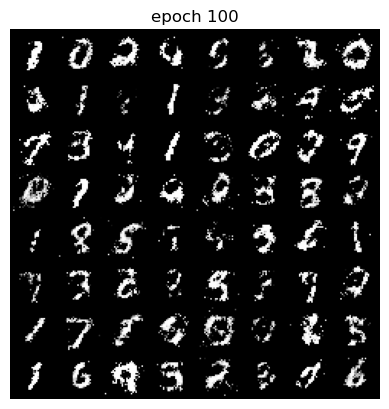

Epoch 100 of 200
Generator loss: 1.66358440, Discriminator loss: 0.91246536


118it [00:14,  7.99it/s]                         


Epoch 101 of 200
Generator loss: 1.58106813, Discriminator loss: 0.91996395


118it [00:14,  7.96it/s]                         


Epoch 102 of 200
Generator loss: 1.68956041, Discriminator loss: 0.87994817


118it [00:14,  8.01it/s]                         


Epoch 103 of 200
Generator loss: 1.78598317, Discriminator loss: 0.83189085


118it [00:14,  7.93it/s]                         


Epoch 104 of 200
Generator loss: 1.71846157, Discriminator loss: 0.86969437


118it [00:14,  7.97it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


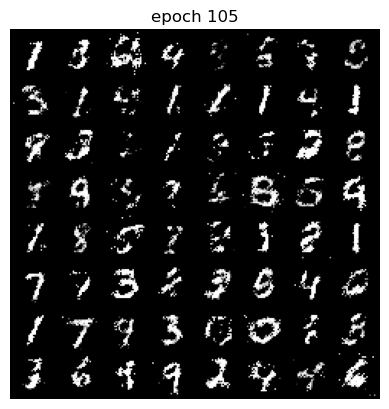

Epoch 105 of 200
Generator loss: 1.72503009, Discriminator loss: 0.86236406


118it [00:14,  7.93it/s]                         


Epoch 106 of 200
Generator loss: 1.66080666, Discriminator loss: 0.88753434


118it [00:14,  7.87it/s]                         


Epoch 107 of 200
Generator loss: 1.61922816, Discriminator loss: 0.92589964


118it [00:14,  7.98it/s]                         


Epoch 108 of 200
Generator loss: 1.69354276, Discriminator loss: 0.89339488


118it [00:15,  7.70it/s]                         


Epoch 109 of 200
Generator loss: 1.68617309, Discriminator loss: 0.86910570


118it [00:16,  7.36it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


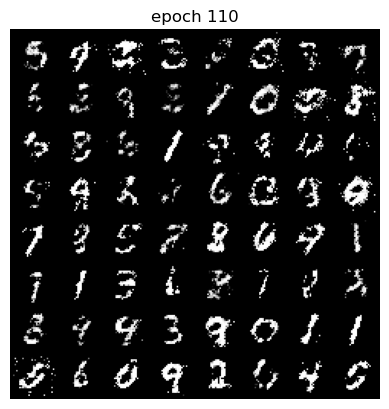

Epoch 110 of 200
Generator loss: 1.70374209, Discriminator loss: 0.88403697


118it [00:14,  7.98it/s]                         


Epoch 111 of 200
Generator loss: 1.63884435, Discriminator loss: 0.90538013


118it [00:14,  7.90it/s]                         


Epoch 112 of 200
Generator loss: 1.78880599, Discriminator loss: 0.85756988


118it [00:14,  7.96it/s]                         


Epoch 113 of 200
Generator loss: 1.73863630, Discriminator loss: 0.87745500


118it [00:14,  7.96it/s]                         


Epoch 114 of 200
Generator loss: 1.59807821, Discriminator loss: 0.92054491


118it [00:14,  7.98it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


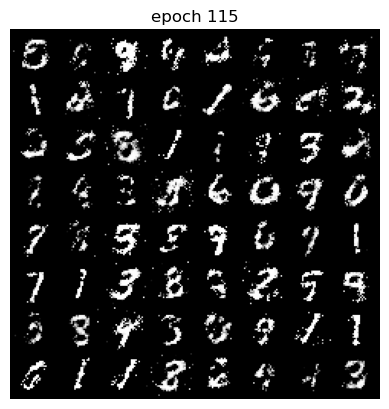

Epoch 115 of 200
Generator loss: 1.83861026, Discriminator loss: 0.82890491


118it [00:15,  7.86it/s]                         


Epoch 116 of 200
Generator loss: 1.64348492, Discriminator loss: 0.92496999


118it [00:14,  7.93it/s]                         


Epoch 117 of 200
Generator loss: 1.64378443, Discriminator loss: 0.88837269


118it [00:14,  7.96it/s]                         


Epoch 118 of 200
Generator loss: 1.73612062, Discriminator loss: 0.87733940


118it [00:14,  7.96it/s]                         


Epoch 119 of 200
Generator loss: 1.60202375, Discriminator loss: 0.89696476


118it [00:14,  7.94it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


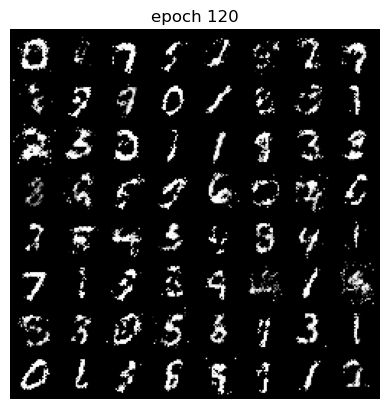

Epoch 120 of 200
Generator loss: 1.68975487, Discriminator loss: 0.89183603


118it [00:14,  7.99it/s]                         


Epoch 121 of 200
Generator loss: 1.67777114, Discriminator loss: 0.88878862


118it [00:14,  7.91it/s]                         


Epoch 122 of 200
Generator loss: 1.68600711, Discriminator loss: 0.87846923


118it [00:15,  7.74it/s]                         


Epoch 123 of 200
Generator loss: 1.72456131, Discriminator loss: 0.86644637


118it [00:14,  7.88it/s]                         


Epoch 124 of 200
Generator loss: 1.83935569, Discriminator loss: 0.81615219


118it [00:15,  7.81it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


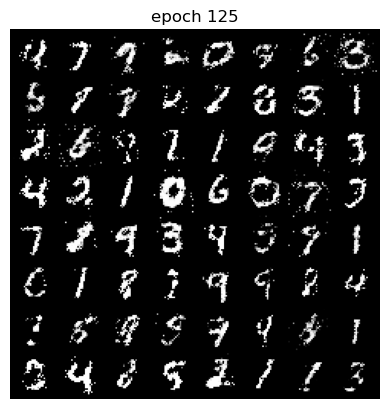

Epoch 125 of 200
Generator loss: 1.75768838, Discriminator loss: 0.85259312


118it [00:14,  7.93it/s]                         


Epoch 126 of 200
Generator loss: 1.75180745, Discriminator loss: 0.85199593


118it [00:15,  7.61it/s]                         


Epoch 127 of 200
Generator loss: 1.67653939, Discriminator loss: 0.88158554


118it [00:15,  7.64it/s]                         


Epoch 128 of 200
Generator loss: 1.50417252, Discriminator loss: 0.95248904


118it [00:15,  7.68it/s]                         


Epoch 129 of 200
Generator loss: 1.56618461, Discriminator loss: 0.90862721


118it [00:15,  7.53it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


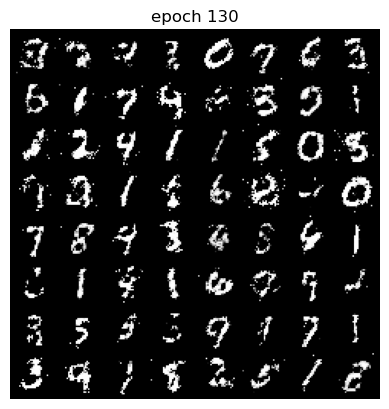

Epoch 130 of 200
Generator loss: 1.55801541, Discriminator loss: 0.93289876


118it [00:14,  7.89it/s]                         


Epoch 131 of 200
Generator loss: 1.56362910, Discriminator loss: 0.92072800


118it [00:15,  7.83it/s]                         


Epoch 132 of 200
Generator loss: 1.54309256, Discriminator loss: 0.94099141


118it [00:15,  7.85it/s]                         


Epoch 133 of 200
Generator loss: 1.58317352, Discriminator loss: 0.92049886


118it [00:15,  7.65it/s]                         


Epoch 134 of 200
Generator loss: 1.57102994, Discriminator loss: 0.92169302


118it [00:16,  7.29it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


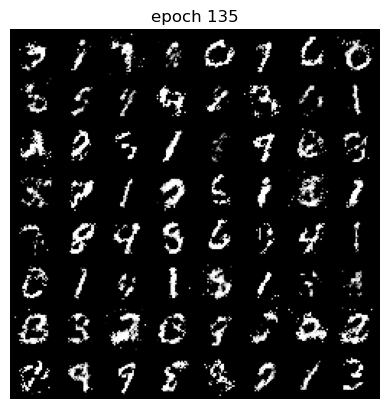

Epoch 135 of 200
Generator loss: 1.63017939, Discriminator loss: 0.90427516


118it [00:15,  7.48it/s]                         


Epoch 136 of 200
Generator loss: 1.57684994, Discriminator loss: 0.90554550


118it [00:15,  7.80it/s]                         


Epoch 137 of 200
Generator loss: 1.54632112, Discriminator loss: 0.93037475


118it [00:15,  7.65it/s]                         


Epoch 138 of 200
Generator loss: 1.57743605, Discriminator loss: 0.92984268


118it [00:15,  7.48it/s]                         


Epoch 139 of 200
Generator loss: 1.61828602, Discriminator loss: 0.89308687


118it [00:16,  7.19it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


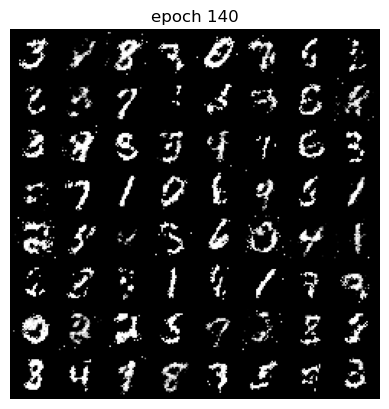

Epoch 140 of 200
Generator loss: 1.65041120, Discriminator loss: 0.90180047


118it [00:16,  7.16it/s]                         


Epoch 141 of 200
Generator loss: 1.62420390, Discriminator loss: 0.89833784


118it [00:17,  6.63it/s]                         


Epoch 142 of 200
Generator loss: 1.66952545, Discriminator loss: 0.87854807


118it [00:16,  7.04it/s]                         


Epoch 143 of 200
Generator loss: 1.66364441, Discriminator loss: 0.91270046


118it [00:14,  7.90it/s]                         


Epoch 144 of 200
Generator loss: 1.55312063, Discriminator loss: 0.90823509


118it [00:14,  7.95it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


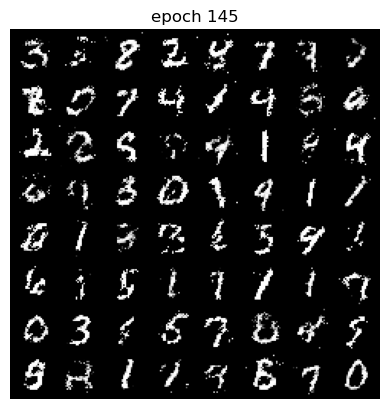

Epoch 145 of 200
Generator loss: 1.51321008, Discriminator loss: 0.93249785


118it [00:15,  7.66it/s]                         


Epoch 146 of 200
Generator loss: 1.57012264, Discriminator loss: 0.92364652


118it [00:14,  7.89it/s]                         


Epoch 147 of 200
Generator loss: 1.46367215, Discriminator loss: 0.97667897


118it [00:15,  7.74it/s]                         


Epoch 148 of 200
Generator loss: 1.44078039, Discriminator loss: 0.98648208


118it [00:15,  7.61it/s]                         


Epoch 149 of 200
Generator loss: 1.42065678, Discriminator loss: 0.99523953


118it [00:17,  6.57it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


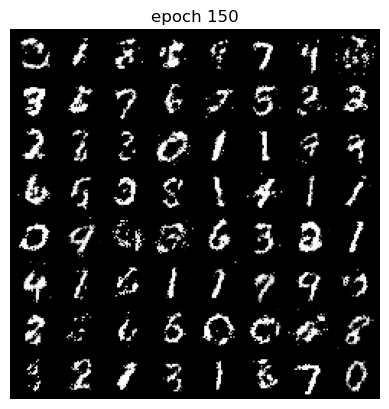

Epoch 150 of 200
Generator loss: 1.51665805, Discriminator loss: 0.94099593


118it [00:16,  7.12it/s]                         


Epoch 151 of 200
Generator loss: 1.55542783, Discriminator loss: 0.93838465


118it [00:16,  7.22it/s]                         


Epoch 152 of 200
Generator loss: 1.48445022, Discriminator loss: 0.96813837


118it [00:16,  7.37it/s]                         


Epoch 153 of 200
Generator loss: 1.46407668, Discriminator loss: 0.98362844


118it [00:15,  7.73it/s]                         


Epoch 154 of 200
Generator loss: 1.46517642, Discriminator loss: 0.96859491


118it [00:15,  7.47it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


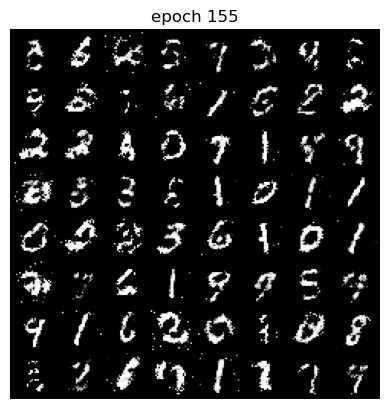

Epoch 155 of 200
Generator loss: 1.42016557, Discriminator loss: 0.98352244


118it [00:15,  7.80it/s]                         


Epoch 156 of 200
Generator loss: 1.51195797, Discriminator loss: 0.95777536


118it [00:16,  7.31it/s]                         


Epoch 157 of 200
Generator loss: 1.49187391, Discriminator loss: 0.90981797


118it [00:17,  6.75it/s]                         


Epoch 158 of 200
Generator loss: 1.49029329, Discriminator loss: 0.96105786


118it [00:14,  7.88it/s]                         


Epoch 159 of 200
Generator loss: 1.53506000, Discriminator loss: 0.95386746


118it [00:15,  7.55it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


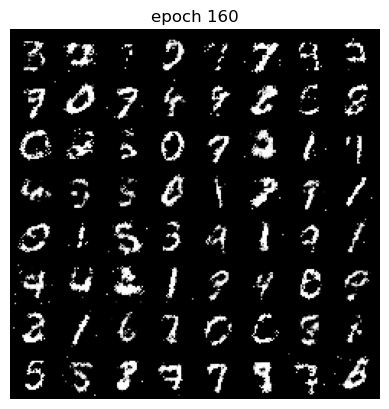

Epoch 160 of 200
Generator loss: 1.52446839, Discriminator loss: 0.94696630


118it [00:15,  7.46it/s]                         


Epoch 161 of 200
Generator loss: 1.43982496, Discriminator loss: 0.98170224


118it [00:16,  7.04it/s]                         


Epoch 162 of 200
Generator loss: 1.43104993, Discriminator loss: 0.97153940


118it [00:18,  6.46it/s]                         


Epoch 163 of 200
Generator loss: 1.56587521, Discriminator loss: 0.92683914


118it [00:17,  6.79it/s]                         


Epoch 164 of 200
Generator loss: 1.51588259, Discriminator loss: 0.93853369


118it [00:16,  7.14it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


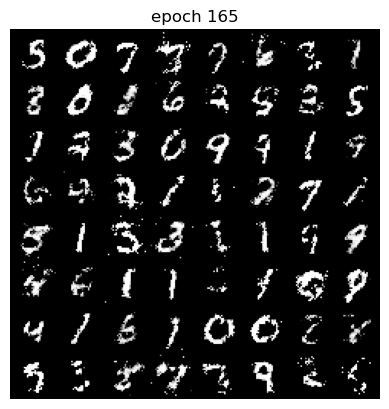

Epoch 165 of 200
Generator loss: 1.53664940, Discriminator loss: 0.92137596


118it [00:15,  7.56it/s]                         


Epoch 166 of 200
Generator loss: 1.55234493, Discriminator loss: 0.91687212


118it [00:15,  7.62it/s]                         


Epoch 167 of 200
Generator loss: 1.52264357, Discriminator loss: 0.95459954


118it [00:15,  7.84it/s]                         


Epoch 168 of 200
Generator loss: 1.49593669, Discriminator loss: 0.97086922


118it [00:14,  7.97it/s]                         


Epoch 169 of 200
Generator loss: 1.49944763, Discriminator loss: 0.95430152


118it [00:14,  7.98it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


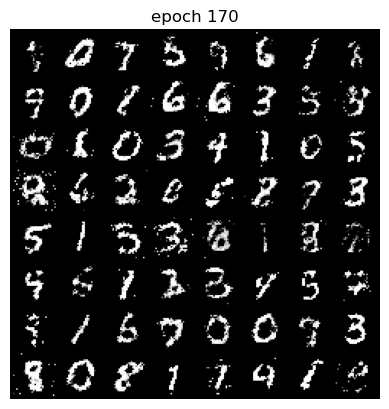

Epoch 170 of 200
Generator loss: 1.50374533, Discriminator loss: 0.93673708


118it [00:15,  7.80it/s]                         


Epoch 171 of 200
Generator loss: 1.55224618, Discriminator loss: 0.93575532


118it [00:15,  7.67it/s]                         


Epoch 172 of 200
Generator loss: 1.61288655, Discriminator loss: 0.92351492


118it [00:15,  7.86it/s]                         


Epoch 173 of 200
Generator loss: 1.60699002, Discriminator loss: 0.90288493


118it [00:14,  7.92it/s]                         


Epoch 174 of 200
Generator loss: 1.53819591, Discriminator loss: 0.95677908


118it [00:14,  8.01it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


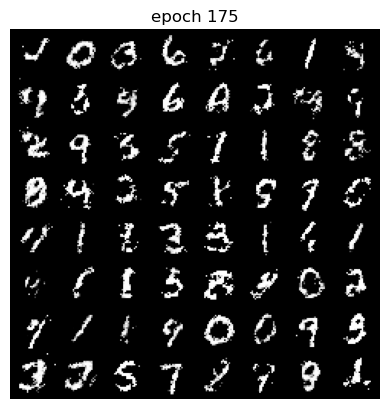

Epoch 175 of 200
Generator loss: 1.49748264, Discriminator loss: 0.94568522


118it [00:17,  6.72it/s]                         


Epoch 176 of 200
Generator loss: 1.46510569, Discriminator loss: 0.98475703


118it [00:15,  7.52it/s]                         


Epoch 177 of 200
Generator loss: 1.49015628, Discriminator loss: 0.96159668


118it [00:14,  7.94it/s]                         


Epoch 178 of 200
Generator loss: 1.43580025, Discriminator loss: 0.99537369


118it [00:15,  7.82it/s]                         


Epoch 179 of 200
Generator loss: 1.49134519, Discriminator loss: 0.95868862


118it [00:14,  7.98it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


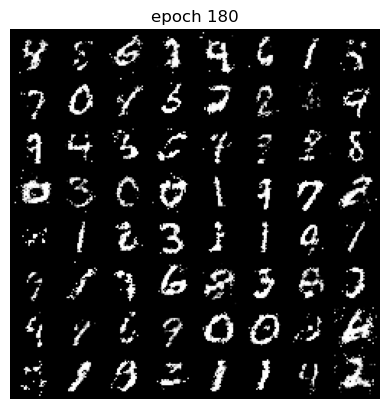

Epoch 180 of 200
Generator loss: 1.40078020, Discriminator loss: 1.00085244


118it [00:14,  7.93it/s]                         


Epoch 181 of 200
Generator loss: 1.36724869, Discriminator loss: 1.01692144


118it [00:14,  8.00it/s]                         


Epoch 182 of 200
Generator loss: 1.42479094, Discriminator loss: 1.00413484


118it [00:14,  8.07it/s]                         


Epoch 183 of 200
Generator loss: 1.32228030, Discriminator loss: 1.03069301


118it [00:14,  8.00it/s]                         


Epoch 184 of 200
Generator loss: 1.42476247, Discriminator loss: 0.97325693


118it [00:15,  7.80it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


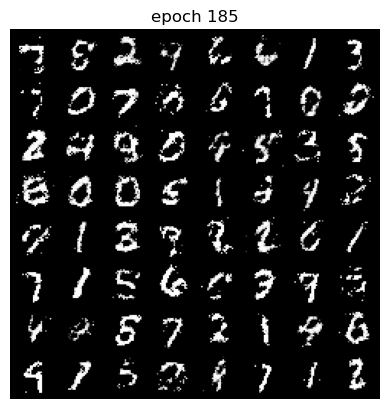

Epoch 185 of 200
Generator loss: 1.45572841, Discriminator loss: 0.98219645


118it [00:15,  7.61it/s]                         


Epoch 186 of 200
Generator loss: 1.44464720, Discriminator loss: 0.98271998


118it [00:15,  7.80it/s]                         


Epoch 187 of 200
Generator loss: 1.39945886, Discriminator loss: 0.99003809


118it [00:14,  7.90it/s]                         


Epoch 188 of 200
Generator loss: 1.40757211, Discriminator loss: 1.00006648


118it [00:15,  7.83it/s]                         


Epoch 189 of 200
Generator loss: 1.38553171, Discriminator loss: 0.98185155


118it [00:14,  8.03it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


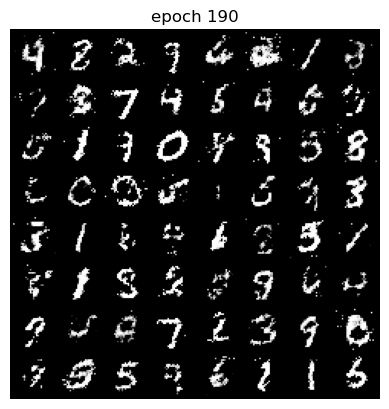

Epoch 190 of 200
Generator loss: 1.47114609, Discriminator loss: 0.98764372


118it [00:15,  7.58it/s]                         


Epoch 191 of 200
Generator loss: 1.42789512, Discriminator loss: 0.98821273


118it [00:14,  7.93it/s]                         


Epoch 192 of 200
Generator loss: 1.48903909, Discriminator loss: 0.95203678


118it [00:14,  7.93it/s]                         


Epoch 193 of 200
Generator loss: 1.45373210, Discriminator loss: 0.98783122


118it [00:15,  7.61it/s]                         


Epoch 194 of 200
Generator loss: 1.35123894, Discriminator loss: 1.02054793


118it [00:16,  7.24it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


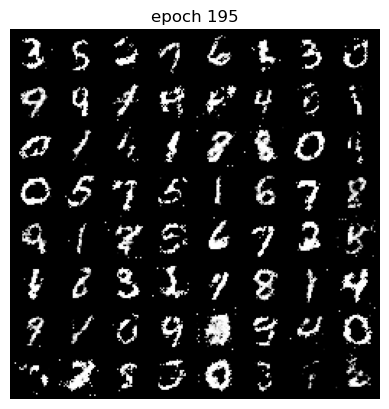

Epoch 195 of 200
Generator loss: 1.48020462, Discriminator loss: 0.96295586


118it [00:16,  7.26it/s]                         


Epoch 196 of 200
Generator loss: 1.40726330, Discriminator loss: 0.99343505


118it [00:16,  7.30it/s]                         


Epoch 197 of 200
Generator loss: 1.49485634, Discriminator loss: 0.95361729


118it [00:15,  7.39it/s]                         


Epoch 198 of 200
Generator loss: 1.42542587, Discriminator loss: 0.98456962


118it [00:17,  6.85it/s]                         


Epoch 199 of 200
Generator loss: 1.45842127, Discriminator loss: 0.96708324


118it [00:15,  7.67it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


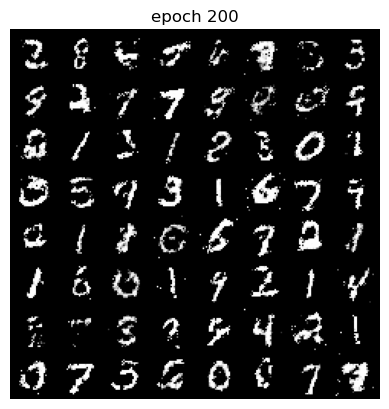

Epoch 200 of 200
Generator loss: 1.32706313, Discriminator loss: 1.03380337


In [16]:
torch.manual_seed(7777)

def generator_loss(output, true_label):
    ############ YOUR CODE HERE #########
    return 1
    
def discriminator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    return 1
    

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ########## 
        real_images = data[0]
        fake_images = generator(noise)
       
        optim_d.zero_grad()
        #Update discriminator for real images.
        labels_d = discriminator(real_images)
        dl_real = criterion(labels_d, label_real(real_images.size(0)))
        dl_real.backward()
        loss_d += dl_real.item() 
    
    
        #Update discriminator for fake images created from noise.
        labels_d = discriminator(fake_images)
        dl_fake = criterion(labels_d, label_fake(fake_images.size(0)))
        dl_fake.backward()
        loss_d += dl_fake.item()
        
        
        optim_d.step()
        
        
        ##GENERATOR:
        fake_images = generator(noise)
        optim_g.zero_grad()
        labels_d = discriminator(fake_images)
        #Generator loss how many images discriminator was able to identify as fake, smaller the better. Run gradient ascent on it.
        gl_fake = criterion(labels_d, label_real(fake_images.size(0)))
        gl_fake.backward()
        optim_g.step()
        
        
        ##Print loss
        loss_g += gl_fake.item()
    
        ######################################
    
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [17]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [18]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

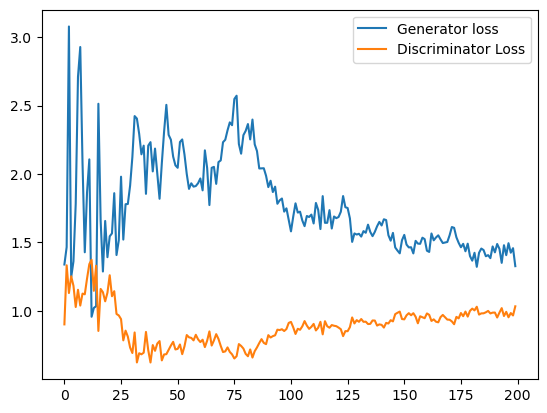

In [19]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')